In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA, NMF

In [41]:
# global plotting params
plt.style.use('ggplot')
# gg plot colors are nice but want seaborn style
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [4]:
import popoff
from average_traces import AverageTraces, SingleCells
from Session import Session, SessionLite

user_paths = popoff.loadpaths.loadpaths()
sys.path.append(os.path.join(user_paths['base_path'], 'popoff', 'scripts'))
sys.path.append(os.path.join(user_paths['vape_path']))

from Session import build_flu_array_single
from utils_funcs import build_flu_array

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


## Add PCA attribute to session object

In [5]:
def pca_session(session, n_components=100, plot=False):
    
    ''' Takes a session object creates [n_components, n_trials, n_frames] array
    Creation of the array is achieved by running PCA on the full fluoresence matrix
    then using "backend" functions from Session.py to create this array in the same way
    as session.behaviour_trials is created. This requires a slightly awkward import and modifcation
    of build_flu_array_X as Session.py was not built to be used in this way
    
    '''
    # Load in the full dff data
    session.load_data()
    run = session.run
    flu = session.run.flu

    # I cannot puzzle out if the artifact is gonna corrupt the PCA calculation. 
    # PCA aims to find vectors that maximis variance when projected onto, but do the (dimensions?
    # datapoints?) that correspond to the artifact corrput the others?
    _, components = do_pca(flu, PCA(n_components=n_components), plot=plot)
    # Hacky but straightforward, stick the components into the run object to send it into
    # build_flu_array_X
    run.comps = components

    # Need to build array [n_cells, n_trials, n_frames] from components in the same 
    # way as session.behaviour_trials is built. 
    
    # PCs are composed of multiple cells, so the don't have different frame
    # start times, so take the average start time across cells
    run.frames_ms = np.tile(np.mean(run.frames_ms, 0), (n_components,1))
    
    
    # TODO: generalise this to 30Hz as well as 5Hz using build_flu_array_single
    arr = build_flu_array(run, session.galvo_ms, pre_frames=session.pre_frames, 
                          post_frames=session.post_frames, use_comps=True)
    # Remove NaN trials
    arr = arr[:, session.nonnan_trials, :]
    session.comps = arr
    
    return session

In [6]:
def do_pca(data, model, plot=False):
 
    X = data
    model.fit(X)
    varexp = np.cumsum(model.explained_variance_ratio_)
    components = model.components_
    

    if plot:
        plt.plot(varexp, label="dff")
        plt.legend()
        plt.xlabel("Num. of components")
        plt.ylabel("Variance explained")
    return varexp, components

Now loading mouse J048, run 27
/home/jrowland/Documents/code/Vape/run_pkls/J048/run27.pkl
microcontroller trial starts occur on average -73.26 ms from galvo trial starts


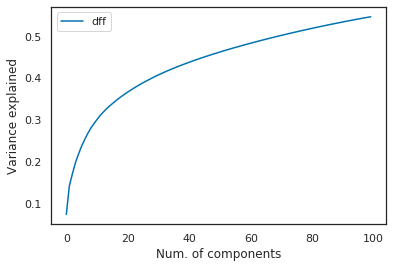

In [7]:
dff = AverageTraces('dff')
dff.build_trace_dict()
session = dff.sessions[2]
session = pca_session(session, n_components=100, plot=True)

# Build logistic regression model

In [8]:
def prepare_data(session, frames='all', model='full', n_comps_include=0):
    
    ''' Prepare fluoresence data in Session object for regression

    Arugments:
    session - Session object to get data from
    frames - Which trial frames (relative to photostim) to return? ['pre', 'post', 'all']
    model - ['full', 'partial'] full = include mean activity of all cells in model
                                partial = include only 'network features' e.g. PCS in model
    n_comps_include - How many PCs to include in the partial model (requires model='partial')
    
    TODO: Currently partial regression parameters are added in a hacky, code repeating way
          Make this much more flexible so the user can specify an argument of which
          parameters to include

    Returns:
    X - data matrix for use as independent variable [n_samples x n_features]
    y - vector for use as dependent variable [n_samples]

    '''
         
    global flu
    # Fluoresence array were are interested in [n_cells x n_trials x n_frames]
    flu = session.behaviour_trials
    # session.frames_use is used to match imaging rates across sessions
    flu = flu[:, :, session.frames_use]
    
    # Just select test trials
    trial_bool = session.photostim==1
    flu = flu[:, trial_bool, :]
    
    # Decode hit vs miss 
    global y
    y = session.decision
    y = y[trial_bool]
    
    # Make sure binary classification
    assert len(set(y)) == 2
    
    # Currently the independent variables are the mean activity across the whole trial
    # for every cell
    
    # Split the trace into pre=frames-before-stim and post=frames-after-stim
    pre = dff.times_use < 0
    post = dff.times_use > 0.6
    remove_artifact = np.logical_or(pre, post)
    
    if model == 'full':
    
        if frames == 'pre':
            flu = flu[:, :, pre]
        elif frames == 'post':
            flu = flu[:, :, post]
        elif frames == 'all':
            flu = flu[:, :, remove_artifact]
        else:
            raise ValueError('Valid frames are ["pre", "post", "all"]')
    
        X = np.mean(flu, 2)
        
    else:
        # Mean population activity on every trial
        x1 = np.mean(flu, (0,2))
        
        # Subtract the mean of pre frames from the mean of post frames -> [n_cells x n_trials]
        sub_frames = lambda arr: np.mean(arr[:, :, post], 2) - np.mean(arr[:, :, pre], 2)
        
        # Average post - pre across all cells
        x2 = np.mean(sub_frames(flu), 0)
        
        # Mean network activity just before the stim
        x3 = np.mean(flu[:, :, pre], (0,2))
        
        # Mean network activity just after the stim
        x4 = np.mean(flu[:, :, post], (0,2))
        
        # Mean trace correlation pre stim
        x5 = []
        for t in range(flu.shape[1]):

            trial = flu[:, t, :]
            trial = trial[:, pre]
            mean_cov = np.mean(np.cov(trial), (0,1))
            x5.append(mean_cov)
            
        # Mean trace correlation post stim
        x6 = []
        for t in range(flu.shape[1]):

            trial = flu[:, t, :]
            trial = trial[:, post]
            mean_cov = np.mean(np.cov(trial), (0,1))
            x6.append(mean_cov)
        
        global PCs
        PCs = session.comps
        PCs = PCs[:, :, session.frames_use]
        PCs = PCs[:, trial_bool, :]
        
        assert n_comps_include <= PCs.shape[0]
        PCs = PCs[0:n_comps_include, :, :]
        
        x7 = sub_frames(PCs)
        
        # Use this if you don't want to subtract but rather mean whole trace (worse performance)
        #x3 = np.mean(PCs[:, :, remove_artifact], 2)
        
#         X = np.vstack((x1,x2))
        X = np.vstack((x1,x2,x3,x4,x5,x6,x7))
        
    # Get input matrix to (n_samples, n_features)
    X = X.T
    # Demean and scale to unit varience
    scaler = sklearn.preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

In [9]:
# For debugging only 
X, y = prepare_data(session, model='partial', n_comps_include=0)

In [10]:
def logistic_regression(X, y, penalty, reg_strength, solver, n_folds=5):
    
    results = []
    models = []

    folds = sklearn.model_selection.StratifiedKFold(n_splits=n_folds)
    
    for train_idx, test_idx in folds.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = sklearn.linear_model.LogisticRegression(penalty=penalty, C=reg_strength,
                                                        class_weight='balanced', solver=solver)
        model.fit(X=X_train, y=y_train)

        models.append(model)
        results.append(model.score(X_test, y_test))
    
    return np.mean(results), np.std(results), models

# Quantify performance as a function of regularisation strength and solver

In [11]:
def performance_vs_reg(X, y, penalty, solvers):
    
    reg_strengths = np.linspace(1e-5, 1, 12)
    
    colors = ['red', 'blue', 'green', 'black', 'grey']
    
    for idx, solver in enumerate(solvers):
        
        means = [] 
        stds = [] 

        for reg_strength in reg_strengths:
            
            # Plotting performance as a function of regularisation strength
            # when there is no regularisation doesnt make sense, but it is 
            # the easiest way to eyeball the plots
            if penalty == 'none':
                reg_strength = 0

            mean_acc, std_acc, _ = logistic_regression(X, y, penalty, reg_strength, solver)
            means.append(mean_acc)
            stds.append(std_acc)

        means = np.array(means)
        stds = np.array(stds)
        sems = stds / 5
        plt.plot(reg_strengths, means, label=solver, color=colors[idx])
        plt.fill_between(reg_strengths, means-sems, means+sems, color=colors[idx], alpha=0.3)
        plt.axhline(0.5, linestyle=':')
    
    plt.legend()
    plt.title(penalty.upper())
    plt.ylim(0.35, 1)
    plt.xlabel('C (Inverse Regularisation Strength)')
    plt.ylabel('Classifier Performance')

In [37]:
n_comps_in_partial = 10

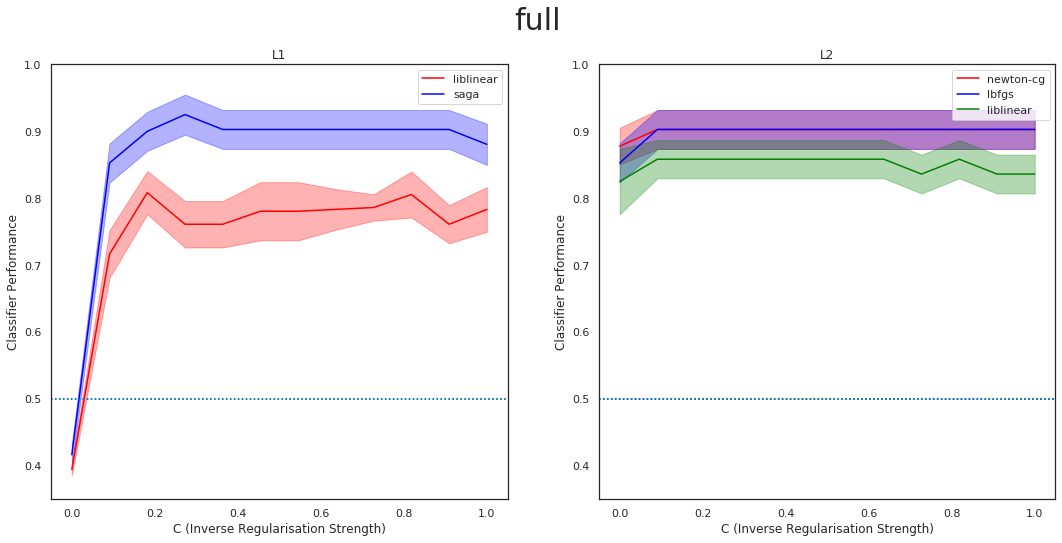

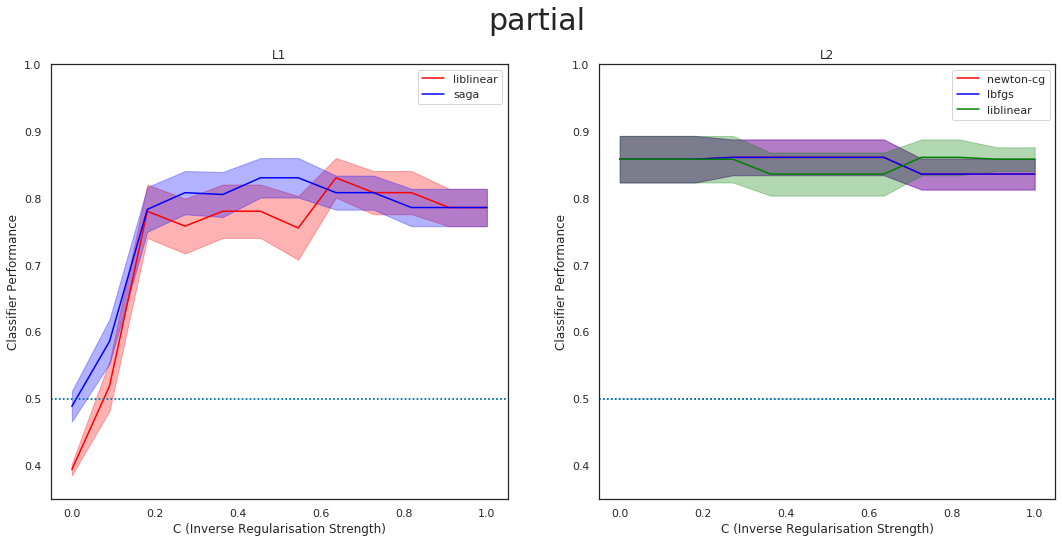

In [38]:
for idx, model_type in enumerate(['full', 'partial']):

    plt.figure(figsize=(18,8))
    plt.suptitle(model_type, fontsize=30)

    X, y = prepare_data(session, 'all', model_type, n_comps_include=n_comps_in_partial)

    solvers_dict = {
        #'none': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'l1': ['liblinear', 'saga'],
        #'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        'l2': ['newton-cg', 'lbfgs', 'liblinear']
    }

    n_plots = 0

    for penalty, solvers in solvers_dict.items():
        n_plots += 1
        plt.subplot(1, len(solvers_dict), n_plots)

        performance_vs_reg(X, y, penalty, solvers)
    

# Examine covariate weights for hand-tuned model

In [39]:
X, y = prepare_data(session, 'all', 'partial', n_comps_include=n_comps_in_partial)
acc, std_acc, models = logistic_regression(X, y, 'l1', 0.5, 'saga')

0.625


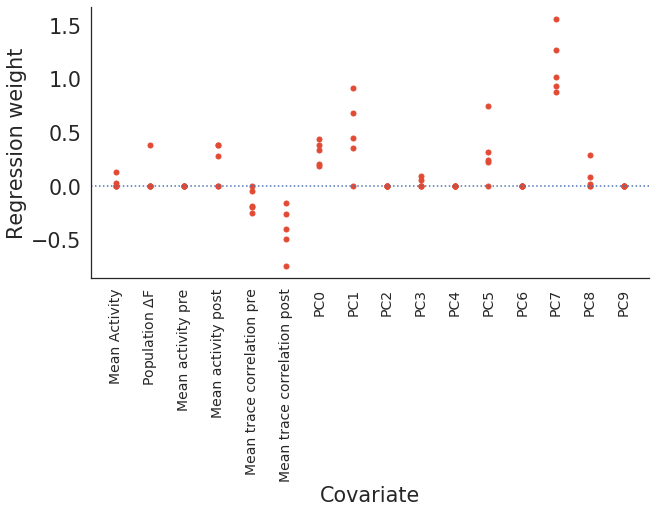

In [42]:
plt.figure(figsize=(10,5))

for model in models:
    coef = np.squeeze(model.coef_)
    plt.plot(coef, '.', markersize=10, color=colors[0])

labels = ['Mean Activity', r'Population $\Delta$F', 'Mean activity pre',
          'Mean activity post', 'Mean trace correlation pre', 'Mean trace correlation post']
[labels.append(f'PC{i}') for i in range(n_comps_in_partial)]

plt.axhline(0, linestyle=':')
plt.ylabel('Regression weight')
plt.xlabel('Covariate')
xt = plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=14)

# Useful for full model, how sparse is B vector -> how many cells important?
print(sum(coef==0) / len(coef))

In [43]:
### Full model performance
X, y = prepare_data(session, 'all', 'full')
mean_full, std_full, _ = logistic_regression(X, y, 'l1', 0.5, 'saga')

In [46]:
### Partial model performance as a function of number of covariates
X, y = prepare_data(session, 'all', 'partial', n_comps_include=n_comps_in_partial)

if n_comps_in_partial > 0:
    idx_covariates = [[0], [0,1], [0,1,2,3], [0,1,2,3,4,5], range(X.shape[1])]
    labels = ['Mean activity only', r'+ Population $\Delta$F', '+ Mean pre & post',
              '+ Correlations pre & post', f'+ {n_comps_in_partial} PCs', 'full model']
else:
    idx_covariates = [[0], [0,1], [0,1,2,3], range(X.shape[1])]
    labels = ['Mean activity only', r'+ Population $\Delta$F', '+ Mean pre & post',
              '+ Correlations pre & post', 'full model']

partial_accs = []
for idx in idx_covariates:

    partial_acc, _, _ = logistic_regression(X[:, idx], y, 'l1', 0.5, 'saga')
    partial_accs.append(partial_acc)

Text(0, 0.5, 'Mean classification accuracy')

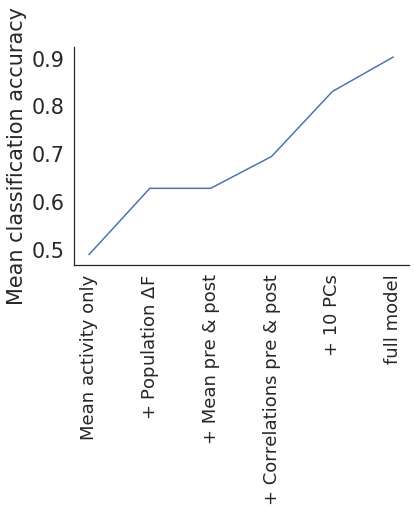

In [47]:
plt.plot(np.append(partial_accs, mean_full))
xt = plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=18)
plt.ylabel('Mean classification accuracy')

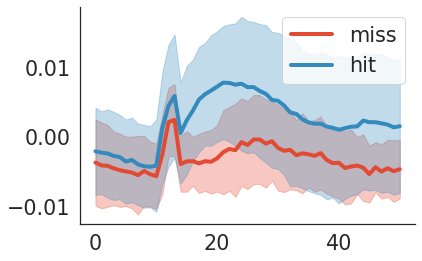

In [48]:
pc_plot = 7

for idx, tt in enumerate(['miss', 'hit']):
    
    trials = PCs[pc_plot, :, :]
    
    trials = trials[y==idx, :]
    
    mean = np.mean(trials, 0)
    std = np.std(trials, 0)
    plt.plot(mean, color=colors[idx], label=tt, linewidth=4)
    plt.fill_between(np.arange(len(mean)), mean-std, mean+std, color=colors[idx], alpha=0.3)
    
plt.legend()

# Quantify classification performance as a function of number of PCs

In [51]:
### Partial model performance as a function of n_components
accs = []
std_accs = []

for n_comps in range(1, 25):

    X, y = prepare_data(session, 'all', 'partial', n_comps_include=n_comps)
    acc, std_acc, _ = logistic_regression(X, y, 'l1', 0.5, 'saga')
    accs.append(acc)
    std_accs.append(std_acc)

accs = np.array(accs)
std_accs = np.array(std_accs)

### Full model performance (repeated n_components times)
X, y = prepare_data(session, 'all', 'full')
mean_full, std_full, _ = logistic_regression(X, y, 'l1', 0.5, 'saga')
mean_full = np.repeat(mean_full, len(accs))
std_full = np.repeat(std_full, len(accs))

Text(0.5, 0, 'Number of Components Included')

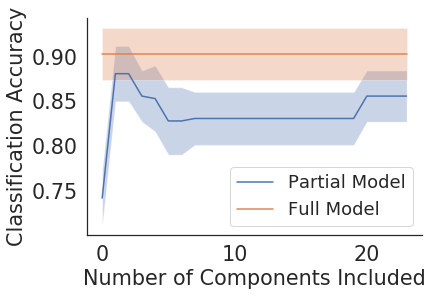

In [52]:
plt.plot(accs, label='Partial Model')
plt.fill_between(np.arange(len(accs)), accs-std_accs/5, accs+std_accs/5, alpha=0.3)

plt.plot(mean_full, label='Full Model')
plt.fill_between(np.arange(len(mean_full)), mean_full-std_full/5, mean_full+std_full/5, alpha=0.3)

plt.legend(fontsize=18)
plt.ylabel('Classification Accuracy')
plt.xlabel('Number of Components Included')


# Misc

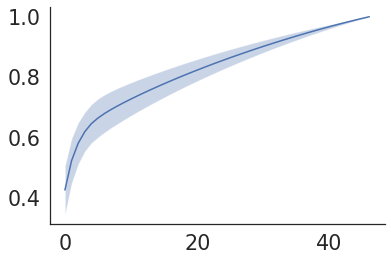

In [23]:
# This is for trial by trial components that will probably be deprecated

flu = session.behaviour_trials[:, :, session.frames_use]

# Split the trace into pre=frames-before-stim and post=frames-after-stim
pre = dff.times_use < 0
post = dff.times_use > 0.6
remove_artifact = np.logical_or(pre, post)

flu = flu[:, :, remove_artifact]

varexps = []
for trial_idx in range(flu.shape[1]):
    trial = flu[:, trial_idx, :]
    varexp, _ = do_pca(trial, PCA(n_components=47))
    varexps.append(varexp)

varexps = np.array(varexps)
mean = np.mean(varexps, 0)
std = np.std(varexps, 0)
plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean-std, mean+std, alpha=0.3)